### Setup


In [1]:
try:
    import transformer_lens
except:
    !pip install git+https://github.com/neelnanda-io/TransformerLens
    !pip install circuitsvis

/home/ubuntu/.conda/envs/matsv2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import itertools
from __future__ import annotations
from dataclasses import dataclass
import os
import pickle
from typing import cast, Generator

import circuitsvis as cv
from matplotlib import pyplot as plt
import torch
from transformer_lens import HookedTransformerConfig, HookedTransformer

In [3]:
import random
from typing import List

### Invariable hyperparameters


In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{DEVICE = }")

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

DEVICE = 'cuda'


### Data generator and datasets


In [5]:
def generate_training_example(
    vocab_min_id, vocab_max_id, seq_length, start_token, require_consecutive
) -> List[int]:
    """
    randomly generate a list of integers with a single pair of consective integers
    first generate a pair of consective integers, then randomly generate the rest
    """
    # Create initial list with a pair of consecutive numbers
    if require_consecutive:
        start = random.randint(vocab_min_id, vocab_max_id - 1)
        input_list = [start, start + 1]
    else:
        input_list = []

    # Generate the rest of the list
    while len(input_list) < seq_length:
        new_num = random.randint(vocab_min_id, vocab_max_id)
        input_list.append(new_num)

    # Shuffle the list to avoid any pattern
    random.shuffle(input_list)

    # generate label
    output_label = []
    input_list_set = set(input_list)

    for l in input_list:
        is_solution = l + 1 in input_list_set or l - 1 in input_list_set
        output_label.append(1 if is_solution else 0)

    # add start token if one is given
    if start_token is not None:
        input_list = [start_token] + input_list
        output_label = [0] + output_label

    return input_list, output_label

In [6]:
def generate_training_batch(batch_size, **kwargs) -> Tensor:
    """
    Generate a batch of training examples
    """
    batch_input = []
    batch_output = []

    for _ in range(batch_size):
        input_list, output_label = generate_training_example(**kwargs)
        batch_input.append(input_list)
        batch_output.append(output_label)

    return tensor(batch_input, dtype=torch.int32), tensor(
        batch_output, dtype=torch.float32
    )

In [7]:
# General generator
def make_data_gen(
    batch_size: int,
    device: int = DEVICE,
    **kwargs,
) -> Generator[Tensor, None, None]:
    while True:
        X, y = generate_training_batch(
            batch_size,
            **kwargs,
        )
        X = X.to(device)
        y = y.to(device)
        yield X, y

### Accuracy and validation


In [8]:
from typing import Tuple


def get_diff_row_inds(
    a: Tensor, b: Tensor  # [dim1, dim2]  # [dim1, dim2]
) -> Tensor:  # [dim1]
    """Find indices of rows where a and b differ"""
    assert a.shape == b.shape
    return ((a == b).prod(dim=1) == 0).nonzero(as_tuple=True)[0]


def soft_acc_fn(logits, labels):
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()
    correct_preds = (preds == labels).float()
    # exclude start of seq token in soft accuracy
    batch_accuracy = correct_preds[:, 1:].sum(dim=1) / (labels.size(1) - 1)
    average_accuracy = batch_accuracy.mean().item()
    return average_accuracy


def hard_acc_fn(logits, labels):
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()
    correct_preds = (preds == labels).float()
    all_correct = correct_preds.sum(dim=1) == labels.size(1)
    accuracy = all_correct.float().mean().item()
    return accuracy


def acc_fn(logits, labels):
    soft_acc = soft_acc_fn(logits, labels)
    hard_acc = hard_acc_fn(logits, labels)
    return soft_acc, hard_acc


def show_mispreds(
    model: HookedTransformer, data: Tuple[Tensor, Tensor]
) -> None:  # [batch, pos]
    """Test this model on `data` and print mispredictions"""
    X, y = data
    logits = model(X).squeeze()
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()
    incorrect_preds = (preds != y).any(dim=1)
    mispreds_with_probs = []

    # Iterate over each incorrect prediction and add to the list
    for idx in incorrect_preds.nonzero(as_tuple=True)[0]:
        mispreds_with_probs.append((X[idx], probs[idx]))

    return mispreds_with_probs

## Training


### Model


In [9]:
def create_model(d_model, n_layers, n_heads, d_heads, n_ctx, d_vocab, attn_only, seed):
    cfg = HookedTransformerConfig(
        d_model=d_model,
        n_layers=n_layers,
        n_heads=n_heads,
        d_head=d_heads,
        n_ctx=n_ctx,
        d_vocab=d_vocab,
        d_vocab_out=1,
        act_fn="relu",
        seed=seed,
        device=DEVICE,
        attn_only=attn_only,
        attention_dir="bidirectional",
    )
    model = HookedTransformer(cfg, move_to_device=True)
    return model

### Training setup


In [10]:
@dataclass(frozen=True)
class TrainingHistory:
    losses: list[float]
    train_accuracies: list[float]
    val_losses: list[float]
    val_accuracies: list[float]


def converged(val_accs: list[float], n_last: int = 10) -> bool:
    return cast(bool, (tensor(val_accs[-n_last:]) == 1).all().item())


def train_model(
    model: HookedTransformer,
    optim,
    scheduler,
    train_gen,
    val_gen,
    n_epochs,
    print_epochs,
) -> TrainingHistory:
    losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    loss_fn = nn.BCEWithLogitsLoss()
    for epoch in range(1, n_epochs + 1):
        X, y = next(train_gen)
        logits = model(X).squeeze()  # dim [batch, pos]
        loss = loss_fn(logits, y)
        loss.backward()
        optim.step()
        optim.zero_grad()
        scheduler.step(loss)

        if epoch % print_epochs == 0:
            val_X, val_y = next(val_gen)
            train_batch_acc = acc_fn(logits, y)

            val_logits = model(val_X).squeeze()
            val_batch_acc = acc_fn(val_logits, val_y)
            val_loss = loss_fn(val_logits, val_y)

            train_accuracies.append(train_batch_acc)
            losses.append(loss.item())
            val_accuracies.append(val_batch_acc)
            val_losses.append(val_loss.item())
            print(
                f"""
                Epoch {epoch}/{n_epochs} ({epoch / n_epochs:.0%}) :
                loss = {loss.item():.10f}; soft_acc = {train_batch_acc[0]:.3%}; hard_acc = {train_batch_acc[1]:.3%};
                val_loss = {val_loss.item():.10f}; val_soft_acc = {val_batch_acc[0]:.3%}; val_hard_acc = {val_batch_acc[1]:.3%};
                lr={scheduler._last_lr[0]};
                """
            )

    return TrainingHistory(losses, train_accuracies, val_losses, val_accuracies)


def load_model_state(model: HookedTransformer, filename: str) -> None:
    assert os.path.isdir("models"), "Make a directory `models` with model state dicts"
    if not filename.startswith("models/"):
        filename = f"models/{filename}"
    with open(filename, "rb") as f:
        state_dict = pickle.load(f)
    model.load_state_dict(state_dict)

In [11]:
def run_training(
    list_length,
    require_consecutive,
    d_vocab,
    attn_only,
    n_layers,
    n_heads,
    d_model,
    d_head,
    n_epochs,
    print_epochs,
    seed,
    start_token,
):
    n_ctx = list_length + 1  # max sequence length incl. start token

    # "Real" tokens range from 1 to D_VOCAB (non-inclusive)
    vocab_min_id = 1
    vocab_max_id = d_vocab - 1

    # If you want to use pretrained weights, replace None by the path to the pkl file.
    # path_pkl_pretrained_weights = None

    # data generators
    data_gen = make_data_gen(
        batch_size=1000,
        vocab_min_id=vocab_min_id,
        vocab_max_id=vocab_max_id,
        seq_length=list_length,
        start_token=start_token,
        require_consecutive=require_consecutive,
    )

    # model
    model = create_model(
        d_model, n_layers, n_heads, d_head, n_ctx, d_vocab, attn_only, seed
    )

    # optimizer
    lr = 1e-4
    betas = (0.9, 0.999)
    optim = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, "min", patience=100)

    # run training
    training_history = train_model(
        model, optim, scheduler, data_gen, data_gen, n_epochs, print_epochs
    )
    return model, training_history, data_gen

In [12]:
hyperparam_config = {"d_vocab": [16], "seed": [700, 701, 702, 703]}
config_names = hyperparam_config.keys()
train_configs = [
    {
        param_name: param_value
        for param_name, param_value in zip(config_names, config_values)
    }
    for config_values in itertools.product(*hyperparam_config.values())
]

In [13]:
train_outputs = {}
for config in train_configs:
    print(config)
    train_outputs[tuple(sorted(config.items()))] = run_training(
        list_length=5,
        attn_only=True,
        n_layers=1,
        n_heads=1,
        d_model=128,
        d_head=32,
        n_epochs=6000,
        print_epochs=6000,
        require_consecutive=True,
        start_token=None,
        **config
    )

{'d_vocab': 16, 'seed': 700}



                Epoch 6000/6000 (100%) :
                loss = 0.2709723711; soft_acc = 85.200%; hard_acc = 50.500%;
                val_loss = 0.2626933157; val_soft_acc = 85.825%; val_hard_acc = 51.000%;
                lr=1.0000000000000004e-08;
                
{'d_vocab': 16, 'seed': 701}

                Epoch 6000/6000 (100%) :
                loss = 0.2715217769; soft_acc = 85.125%; hard_acc = 49.400%;
                val_loss = 0.2627502978; val_soft_acc = 86.575%; val_hard_acc = 52.400%;
                lr=1.0000000000000004e-08;
                
{'d_vocab': 16, 'seed': 702}

                Epoch 6000/6000 (100%) :
                loss = 0.2737295926; soft_acc = 86.025%; hard_acc = 53.900%;
                val_loss = 0.2644878924; val_soft_acc = 86.275%; val_hard_acc = 53.600%;
                lr=1.0000000000000004e-08;
                
{'d_vocab': 16, 'seed': 703}

                Epoch 6000/6000 (100%) :
                loss = 0.2605302036; soft_acc = 86.225%; hard_acc =

In [14]:
train_config = {"d_vocab": 16, "seed": 702}
model, history, data_gen = train_outputs[tuple(sorted((train_config.items())))]

Investigate attention patterns


In [16]:
test_input = torch.tensor([13, 7, 6, 4, 7])

# Pass through model, get cache and predictions
logits, cache_model = model.run_with_cache(test_input, remove_batch_dim=True)
probs = torch.sigmoid(logits.squeeze())

# Get attention pattern and plot it
attention_pattern = cache_model["pattern", 0, "attn"]
tokens_input = list(map(str, test_input))
print(test_input)
print(probs)

cv.attention.attention_patterns(tokens=tokens_input, attention=attention_pattern)

tensor([13,  7,  6,  4,  7])
tensor([0.5768, 0.9186, 0.9754, 0.7185, 0.9176], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


### Retrain a model with a start token


In [17]:
hyperparam_config = {"d_vocab": [16], "seed": [700, 701, 702, 703]}
config_names = hyperparam_config.keys()
train_configs = [
    {
        param_name: param_value
        for param_name, param_value in zip(config_names, config_values)
    }
    for config_values in itertools.product(*hyperparam_config.values())
]

In [18]:
train_outputs = {}
for config in train_configs:
    print(config)
    train_outputs[tuple(sorted(config.items()))] = run_training(
        list_length=5,
        attn_only=True,
        n_layers=1,
        n_heads=1,
        d_model=128,
        d_head=32,
        n_epochs=6000,
        print_epochs=6000,
        require_consecutive=True,
        start_token=0,
        **config
    )

{'d_vocab': 16, 'seed': 700}



                Epoch 6000/6000 (100%) :
                loss = 0.0000117782; soft_acc = 100.000%; hard_acc = 100.000%;
                val_loss = 0.0000117849; val_soft_acc = 100.000%; val_hard_acc = 100.000%;
                lr=0.0001;
                
{'d_vocab': 16, 'seed': 701}

                Epoch 6000/6000 (100%) :
                loss = 0.0000161294; soft_acc = 100.000%; hard_acc = 100.000%;
                val_loss = 0.0000155557; val_soft_acc = 100.000%; val_hard_acc = 100.000%;
                lr=0.0001;
                
{'d_vocab': 16, 'seed': 702}

                Epoch 6000/6000 (100%) :
                loss = 0.0000189253; soft_acc = 100.000%; hard_acc = 100.000%;
                val_loss = 0.0000194690; val_soft_acc = 100.000%; val_hard_acc = 100.000%;
                lr=0.0001;
                
{'d_vocab': 16, 'seed': 703}

                Epoch 6000/6000 (100%) :
                loss = 0.0000125721; soft_acc = 100.000%; hard_acc = 100.000%;
                val_loss

In [33]:
train_config = {"d_vocab": 16, "seed": 702}
model, history, data_gen = train_outputs[tuple(sorted((train_config.items())))]

In [39]:
test_input = torch.tensor([0, 3, 4, 8, 12, 15])

# Pass through model, get cache and predictions
logits, cache_model = model.run_with_cache(test_input, remove_batch_dim=True)
probs = torch.sigmoid(logits.squeeze())

# Get attention pattern and plot it
attention_pattern = cache_model["pattern", 0, "attn"]
tokens_input = list(map(str, test_input))
print(test_input)
print(probs)

cv.attention.attention_patterns(tokens=tokens_input, attention=attention_pattern)

tensor([ 0,  3,  4,  8, 12, 15])
tensor([1.9080e-06, 9.9996e-01, 9.9997e-01, 2.5462e-05, 3.4682e-05, 1.6641e-05],
       device='cuda:0', grad_fn=<SigmoidBackward0>)


The attention matrix seems messy and it turns out it's because it's undertrained even though it gets 100% accuracy (loss can still go down a several orders of magnitude). Attention matrices of models trained fully are given later.


### Train a model with $d_{head}$ < $d_{vocab}$


In [44]:
hyperparam_config = {"d_vocab": [256], "seed": [734]}
config_names = hyperparam_config.keys()
train_configs = [
    {
        param_name: param_value
        for param_name, param_value in zip(config_names, config_values)
    }
    for config_values in itertools.product(*hyperparam_config.values())
]

In [45]:
train_outputs = {}
for config in train_configs:
    print(config)
    train_outputs[tuple(sorted(config.items()))] = run_training(
        list_length=5,
        attn_only=True,
        n_layers=1,
        n_heads=1,
        d_model=128,
        d_head=32,
        n_epochs=30000,
        print_epochs=10000,
        require_consecutive=True,
        start_token=0,
        **config
    )

{'d_vocab': 256, 'seed': 734}



                Epoch 10000/30000 (33%) :
                loss = 0.0002172176; soft_acc = 100.000%; hard_acc = 100.000%;
                val_loss = 0.0001755614; val_soft_acc = 100.000%; val_hard_acc = 100.000%;
                lr=1.0000000000000004e-08;
                

                Epoch 20000/30000 (67%) :
                loss = 0.0000978389; soft_acc = 100.000%; hard_acc = 100.000%;
                val_loss = 0.0000947684; val_soft_acc = 100.000%; val_hard_acc = 100.000%;
                lr=1.0000000000000004e-08;
                

                Epoch 30000/30000 (100%) :
                loss = 0.0000862827; soft_acc = 100.000%; hard_acc = 100.000%;
                val_loss = 0.0000981896; val_soft_acc = 100.000%; val_hard_acc = 100.000%;
                lr=1.0000000000000004e-08;
                


In [46]:
train_config = {"d_vocab": 256, "seed": 734}
model, history, data_gen = train_outputs[tuple(sorted((train_config.items())))]

Visualize attention matrix


In [47]:
queries = model.W_E @ model.W_Q.squeeze()
keys = model.W_E @ model.W_K.squeeze()
attn_scores = queries @ keys.T
attn = torch.softmax(attn_scores, axis=1)

In [61]:
def generate_heatmap(data: torch.Tensor, title: str, xlabel: str, ylabel: str):
    # Plotting the heatmap
    plt.figure(figsize=(10, 8))
    plt.imshow(
        data.detach().cpu().numpy(), cmap="viridis", aspect="auto"
    )  # 'viridis' is a good colormap for heatmaps
    plt.colorbar()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

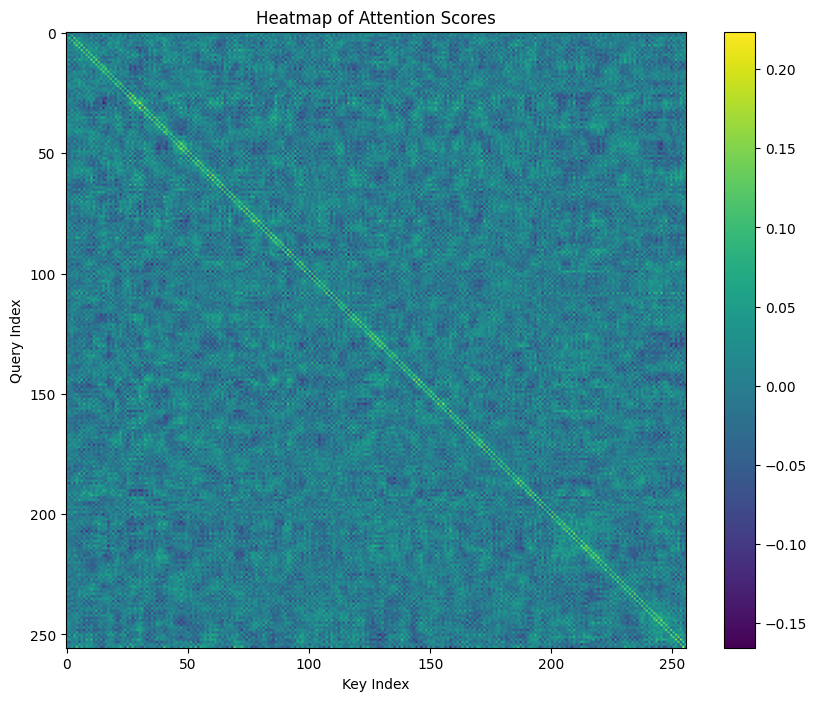

In [62]:
# Convert softmax tensor to numpy for plotting (if not already in CPU and in numpy format)
generate_heatmap(
    title="Heatmap of Attention Scores",
    xlabel="Key Index",
    ylabel="Query Index",
    data=attn_scores,
)

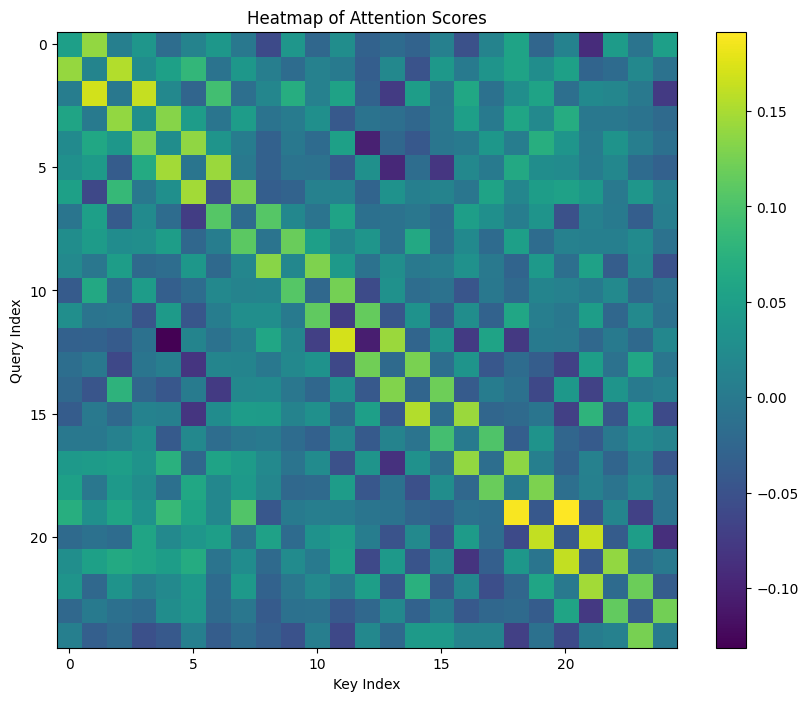

In [64]:
# Convert softmax tensor to numpy for plotting (if not already in CPU and in numpy format)
generate_heatmap(
    title="Heatmap of Attention Scores",
    xlabel="Key Index",
    ylabel="Query Index",
    data=attn_scores[125:150, 125:150],
)

### Train a model with $d_{head} = 2$


In [67]:
hyperparam_config = {"d_vocab": [8 + 1], "seed": [615]}
config_names = hyperparam_config.keys()
train_configs = [
    {
        param_name: param_value
        for param_name, param_value in zip(config_names, config_values)
    }
    for config_values in itertools.product(*hyperparam_config.values())
]

In [68]:
train_outputs = {}
for config in train_configs:
    print(config)
    train_outputs[tuple(sorted(config.items()))] = run_training(
        list_length=4,
        attn_only=True,
        n_layers=1,
        n_heads=1,
        d_model=128,
        d_head=2,
        n_epochs=30000,
        print_epochs=10000,
        require_consecutive=False,
        start_token=0,
        **config
    )

{'d_vocab': 9, 'seed': 615}



                Epoch 10000/30000 (33%) :
                loss = 0.0000725485; soft_acc = 100.000%; hard_acc = 100.000%;
                val_loss = 0.0000674587; val_soft_acc = 100.000%; val_hard_acc = 100.000%;
                lr=1.0000000000000004e-08;
                

                Epoch 20000/30000 (67%) :
                loss = 0.0000671416; soft_acc = 100.000%; hard_acc = 100.000%;
                val_loss = 0.0000656922; val_soft_acc = 100.000%; val_hard_acc = 100.000%;
                lr=1.0000000000000004e-08;
                

                Epoch 30000/30000 (100%) :
                loss = 0.0000681520; soft_acc = 100.000%; hard_acc = 100.000%;
                val_loss = 0.0000690681; val_soft_acc = 100.000%; val_hard_acc = 100.000%;
                lr=1.0000000000000004e-08;
                


In [74]:
train_config = {"d_vocab": 9, "seed": 615}
model, history, data_gen = train_outputs[tuple(sorted((train_config.items())))]

In [95]:
import numpy as np
import matplotlib.pyplot as plt


def plot_vectors(a, b, title, xlabel, ylabel):
    # Create a new figure
    plt.figure(figsize=(10, 10))

    offset = 0.01  # Control this value to adjust the space between the text and the vector head
    # Plot each vector in 'a'
    for i in range(len(a)):
        plt.quiver(
            0,
            0,
            a[i, 0],
            a[i, 1],
            angles="xy",
            scale_units="xy",
            scale=1,
            color="red",
            alpha=0.8,
        )
        # Add a small offset to the position for the text label
        plt.text(
            a[i, 0] + offset * (a[i, 0] / np.linalg.norm(a[i])),
            a[i, 1] + offset * (a[i, 1] / np.linalg.norm(a[i])),
            f"{i + 1}",
            color="red",
            fontsize=12,
            ha="center",
            va="center",
        )

    # Plot each vector in 'b'
    for i in range(len(b)):
        plt.quiver(
            0,
            0,
            b[i, 0],
            b[i, 1],
            angles="xy",
            scale_units="xy",
            scale=1,
            color="blue",
            alpha=0.8,
        )
        # Add a small offset to the position for the text label
        plt.text(
            b[i, 0] + offset * (b[i, 0] / np.linalg.norm(b[i])),
            b[i, 1] + offset * (b[i, 1] / np.linalg.norm(b[i])),
            f"{i + 1}",
            color="blue",
            fontsize=12,
            ha="center",
            va="center",
        )

    # Collect all vector endpoints to determine plot limits
    all_vectors = np.concatenate([a, b], axis=0)
    max_val = np.max(np.abs(all_vectors)) * 1.1  # Adding a 10% margin

    # Set the aspect of the plot to be equal and set plot limits
    plt.axis("equal")
    plt.xlim(-max_val, max_val)
    plt.ylim(-max_val, max_val)

    # Set labels and a title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Add a grid for better visualization
    plt.grid(True)

    # Show the plot
    plt.show()

In [96]:
queries = model.W_E @ model.W_Q.squeeze()
keys = model.W_E @ model.W_K.squeeze()
attn_scores = queries @ keys.T
attn = torch.softmax(attn_scores, axis=1)

In [97]:
np_queries = queries.detach().cpu().numpy()
np_keys = keys.detach().cpu().numpy()

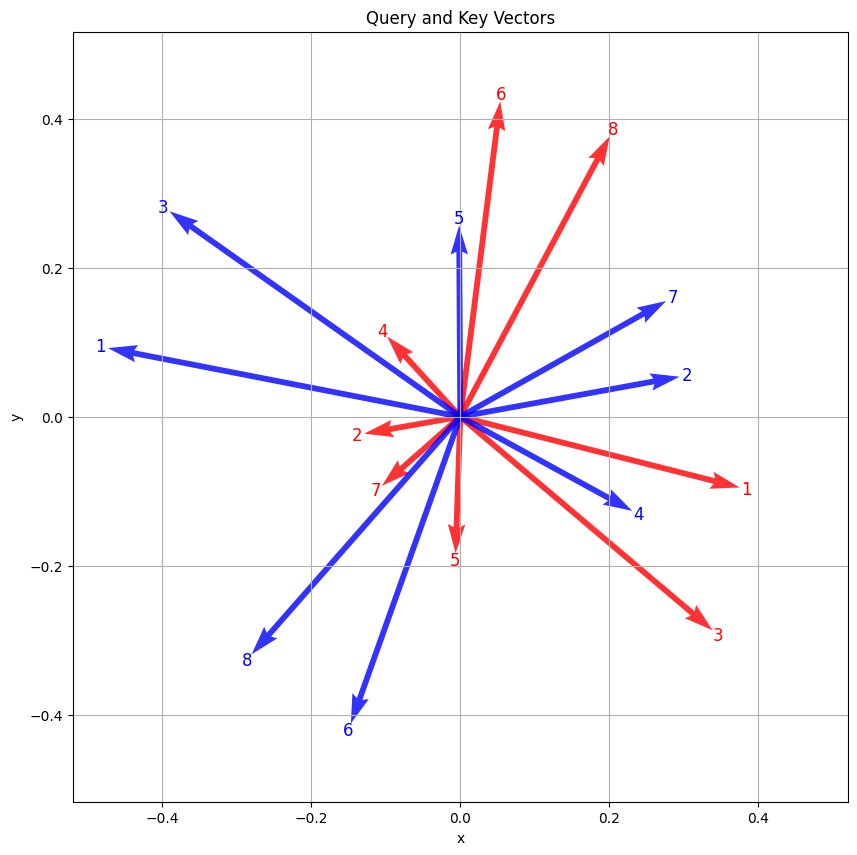

In [98]:
plot_vectors(
    np_queries[1:], np_keys[1:], xlabel="x", ylabel="y", title="Query and Key Vectors"
)

### Train a model with $d_{head}$ > 2 and visualize the checkerboard attention


In [102]:
hyperparam_config = {"d_vocab": [16 + 1], "seed": [790]}
config_names = hyperparam_config.keys()
train_configs = [
    {
        param_name: param_value
        for param_name, param_value in zip(config_names, config_values)
    }
    for config_values in itertools.product(*hyperparam_config.values())
]

In [103]:
train_outputs = {}
for config in train_configs:
    print(config)
    train_outputs[tuple(sorted(config.items()))] = run_training(
        list_length=5,
        attn_only=True,
        n_layers=1,
        n_heads=1,
        d_model=128,
        d_head=4,
        n_epochs=30000,
        print_epochs=10000,
        require_consecutive=False,
        start_token=0,
        **config
    )

{'d_vocab': 17, 'seed': 790}



                Epoch 10000/30000 (33%) :
                loss = 0.0000022809; soft_acc = 100.000%; hard_acc = 100.000%;
                val_loss = 0.0000022879; val_soft_acc = 100.000%; val_hard_acc = 100.000%;
                lr=0.0001;
                

                Epoch 20000/30000 (67%) :
                loss = 0.0000000061; soft_acc = 100.000%; hard_acc = 100.000%;
                val_loss = 0.0000000060; val_soft_acc = 100.000%; val_hard_acc = 100.000%;
                lr=1.0000000000000004e-08;
                

                Epoch 30000/30000 (100%) :
                loss = 0.0000000066; soft_acc = 100.000%; hard_acc = 100.000%;
                val_loss = 0.0000000059; val_soft_acc = 100.000%; val_hard_acc = 100.000%;
                lr=1.0000000000000004e-08;
                


In [104]:
train_config = {"d_vocab": 17, "seed": 790}
model, history, data_gen = train_outputs[tuple(sorted((train_config.items())))]

In [105]:
queries = model.W_E @ model.W_Q.squeeze()
keys = model.W_E @ model.W_K.squeeze()
attn_scores = queries @ keys.T
attn = torch.softmax(attn_scores, axis=1)

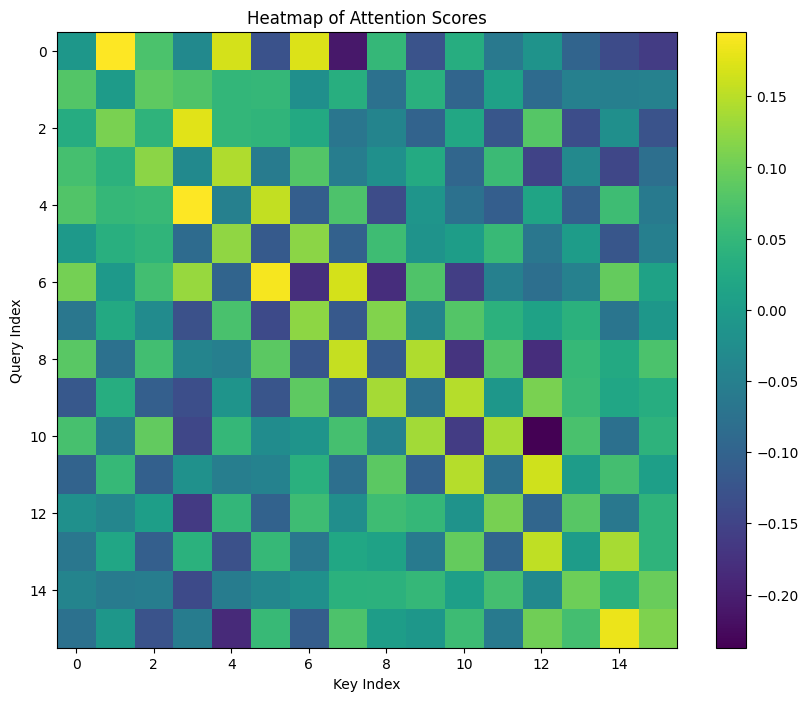

In [107]:
generate_heatmap(
    title="Heatmap of Attention Scores",
    xlabel="Key Index",
    ylabel="Query Index",
    data=attn_scores[1:, 1:],
)